# Analyze A/B Test Results

# Table of Contents

 Introduction

Part I - Probability

Part II - A/B Test

Part III - Regression

# Introduction

A company has developed a new e-commerce web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product.

The main goal of this project was to understand the results of an A/B test run by the website and provide statistical and practical interpretation on the test results.

# Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline


1. Now, read in the ab_data.csv data.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
print('Number of rows in the dataset is {}.'.format(df.shape[0]))

Number of rows in the dataset is 294478.


c. The number of unique users in the dataset.

In [4]:
print('Number of unique users in the dataset is {}.'.format(df.user_id.nunique()))

Number of unique users in the dataset is 290584.


d. The proportion of users converted.

In [5]:
prop_users_converted = round(df.converted.mean() * 100)
print('The proportion of users converted is {}%.'.format(prop_users_converted))

The proportion of users converted is 12%.



e. The number of times the new_page and treatment don't line up.

In [6]:
num_not_aligned = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]
print('The number of times the new_page and treatment don\'t line up is {}.'.format(num_not_aligned))

The number of times the new_page and treatment don't line up is 3893.


f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

# Answer:  There are no missing values in the dataset

2. For the rows where treatment is not aligned with new_page or control is not aligned with old_page, we cannot be sure if this row truly received the new or old page. We will remove these rows as we should use the rows where we can feel confident in the accuracy of data.

In [8]:
df2 = df.copy()
df2 = df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) != False]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

3. Remove duplicates.

a. How many unique user_ids are in df2?

In [10]:
print('Number of unique users in the dataset is {}.'.format(df2.user_id.nunique()))

Number of unique users in the dataset is 290584.


b. There is one user_id repeated in df2. What is it?

In [11]:
print('The repeated user_id in df2 is {}.'.format(df2[df2.user_id.duplicated()].user_id.iloc[0]))

The repeated user_id in df2 is 773192.


c. What is the row information for the repeat user_id?

In [12]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove one of the rows with a duplicate user_id, but keep your dataframe as df2.

In [13]:
df2.drop(2893, inplace=True)
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


4. Use df2 in the below cells to answer some questions:

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
conv_prob = df2.converted.mean()
print('The probability of an individual converting regardless of the page they receive is {}.'.format(conv_prob))

The probability of an individual converting regardless of the page they receive is 0.11959708724499628.


b. Given that an individual was in the control group, what is the probability they converted?

In [15]:
conv_prob_control = df2[df2.group == 'control'].converted.mean()
print('Given that an individual was in the control group, the probability they converted is {}.'.format(conv_prob_control))

Given that an individual was in the control group, the probability they converted is 0.1203863045004612.


c. Given that an individual was in the treatment group, what is the probability they converted?

In [16]:
conv_prob_treatment = df2[df2.group == 'treatment'].converted.mean()
print('Given that an individual was in the treatment group, the probability they converted is {}.'.format(conv_prob_treatment))


Given that an individual was in the treatment group, the probability they converted is 0.11880806551510564.



d. What is the probability that an individual received the new page?

In [17]:
new_page_prob = (df2['landing_page'] == "new_page").mean()
print('The probability that an individual received the new page is {}.'.format(new_page_prob))

The probability that an individual received the new page is 0.5000619442226688.


e. Is there sufficient evidence to say that the new treatment page leads to more conversions?

# Answer:
There is no sufficient evidence to say that the new treatment page leads to more conversions (the conversion probability for each page is 'almost' the same). Moreover, the probability of conversion of the control group is even slightly higher than the probability of conversion of the treatment group (conv_prob_control > conv_prob_treatment). The number of events leading to old and new pages is well ballanced (new_page_prob) for each page type (there is no bias existing potentially disturbing existence of the evidence). 

# Part II - A/B Test

1. It is assumed that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. The null and alternative hypotheses are ($p_{old}$ and $p_{new}$, which are the converted rates for the old and new pages):


H_0 : p_{new} - p_{old} \leq 0 \\ H_1 : p_{new} - p_{old} &gt; 0


2. It is assumed under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the converted success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, it is assumed they are equal to the converted rate in ab_data.csv regardless of the page.

a. What is the convert rate for $p_{new}$ under the null?

In [18]:
p_new = conv_prob
p_new

0.11959708724499628

b. What is the convert rate for $p_{old}$ under the null?

In [19]:
p_old = conv_prob
p_old

0.11959708724499628

c. What is $n_{new}$?

In [20]:
n_old = df2[df2.landing_page == 'old_page'].shape[0]
n_old

145274

e. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null. Store these $n_{old}$ 1's and 0's in old_page_converted.

In [24]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_old), p_old])
old_page_converted.mean()

0.1209232209480017

f. Plot a histogram of the p_diffs.

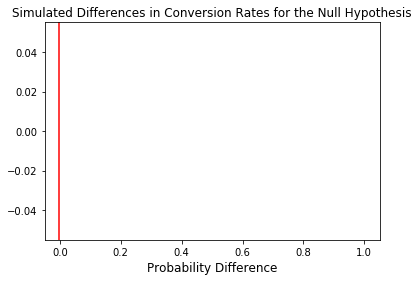

In [29]:
obs_diff = conv_prob_treatment - conv_prob_control
p_diffs = np.asarray(p_diffs)
plt.hist(p_diffs)
plt.title("Simulated Differences in Conversion Rates for the Null Hypothesis", fontsize=12)
plt.xlabel("Probability Difference", fontsize=12)
plt.axvline(obs_diff, color='r');

g. We could also use a built-in to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let n_old and n_new refer the the number of rows associated with the old page and new pages, respectively.

# Part III - A regression approach

1. Confirm that the result achieved in the previous A/B test can also be acheived by performing regression.

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Answer: Because we are dealing with binary output, Logistic regression should be used.

b. The goal is to use statsmodels to fit the regression model you specified in part a. to see if there is a significant difference in conversion based on which page a customer receives. First we need to create a column for the intercept, and create a dummy variable column for which page each user received. Add an intercept column, as well as an ab_page column, which is 1 when an individual receives the treatment and 0 if control.

In [32]:
df2['intercept'] = 1
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1



c. Use statsmodels to import your regression model. Instantiate the model, and fit the model using the two columns you created in part b. to predict whether or not an individual converts.

In [33]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 01 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        21:55:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with ab_page? Why does it differ from the value you found in Part II?

# Answer:
The p-value calculated here is 0.190. This is because the Logit Regression is based on a two-tailed test. 0.190 is still greater then 0.05 (our $\alpha$), so we still cannot reject our null hypothesis.



f. Now, you are considering other things that might influence whether or not an individual converts. Discuss why it is a good idea to consider other factors to add into your regression model. Are there any disadvantages to adding additional terms into your regression model?

# Answer: 
The convert rate may be related to some features of users like nationality, age, gender or specific cultural behavior. Adding additional information about users could reveal hidden value of the new version of the page for specific group of the users


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the countries.csv dataset and merge together your datasets on the approporiate rows.

Does it appear that country had an impact on conversion?

In [35]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0


In [36]:
# Check what countries are in the new dataset
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [37]:
### Create the necessary dummy variables
df_new[['ca', 'uk', 'us']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,ca,uk,us
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0


In [38]:
# Train the model
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'uk', 'us']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 01 Jul 2020   Pseudo R-squ.:               1.521e-05
Time:                        22:01:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
uk             0.0507      0.028      1.786      0.074      -0.005       0.106
us             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

# Answer: 
The p-values for the countries are above 0.05, so again we cannot reject the null hypothesis. Countries do not influence significantly differences in the conversion rates

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. Create the necessary additional columns, and fit the new model.

Provide the summary results, and your conclusions based on the results.

In [39]:
# Create additional columns specifying what user/country converted
df_new['us_page'] = df_new['us'] * df_new['ab_page']
df_new['uk_page'] = df_new['uk'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,ca,uk,us,us_page,uk_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0,0,1


In [40]:
### Fit Your Linear Model And Obtain the Results
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'us', 'uk', 'us_page', 'uk_page']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 01 Jul 2020   Pseudo R-squ.:               3.482e-05
Time:                        22:05:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
us             0.0175      0.038      0.465      0.642      -0.056       0.091
uk             0.0118      0.040      0.296      0.767      -0.066       0.090
us_page        0.0469      0.054      0.872      0.383      -0.059       0.152
uk_page        0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

# Answer:
Looking at p-values for all variables (all higher than 0.05) we can say that interactions between page and country have no significant effects on conversion.

# Conclusions
The conclusion of the whole study and the general result is that we do not have sufficient evidence to suggest that the new page results in more conversions than the old one.

Although there could be other variables identified regarding users which could result in rejecting our null hypothesis (and would require additional resources/money and time), the so-far analysis results would bias me toward suggesting to drop the new page as not bringing much value and focus on something else (maybe another brand new page with other features to test).